# Travelling Salesman Problem using Quantum Phase Estimation


## 1) Representação do problema utilizando Grafos

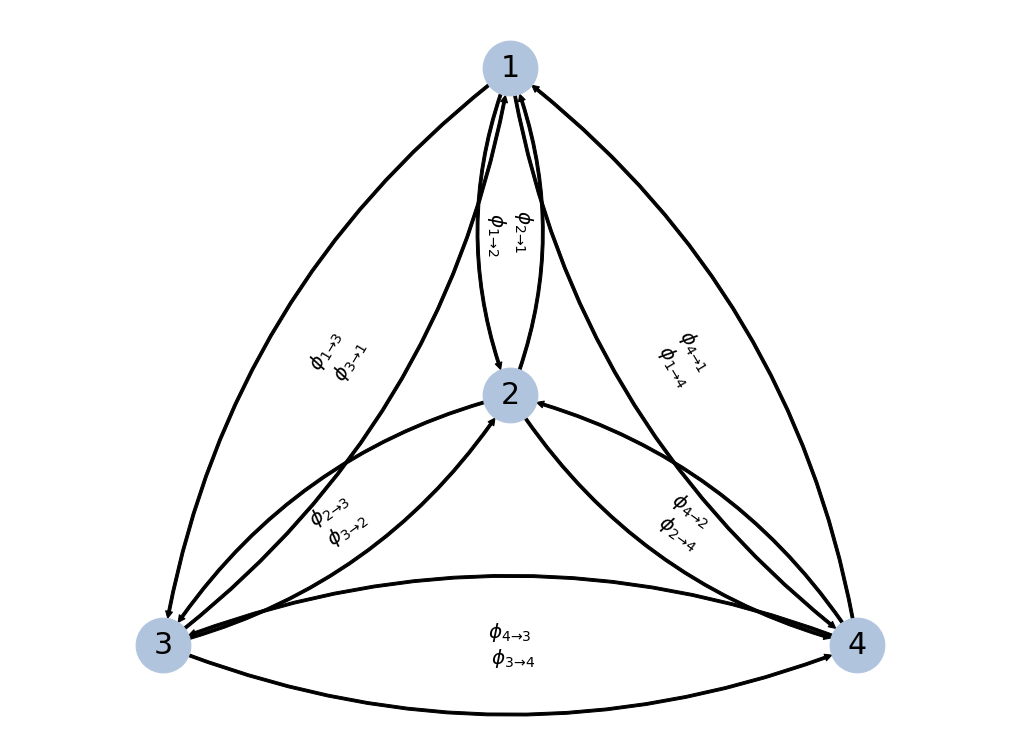

In [1]:
# Building the graph with nodes = 4

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed=True)
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)

G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 4)

G.add_edge(2, 1)
G.add_edge(2, 3)
G.add_edge(2, 4)

G.add_edge(3, 1)
G.add_edge(3, 2)
G.add_edge(3, 4)

G.add_edge(4, 1)
G.add_edge(4, 2)
G.add_edge(4, 3)

pos = {1: [0.75, 1.0],
      2: [0.75, 0.15],
      3: [0.5, -0.5],
      4: [1.0, -0.5]}


edge_labels = {(1, 2): '$\\phi_{2\\to 1}$\n $\\phi_{1\\to 2}$',
              (1, 3): '$\\phi_{1\\to 3}$\n $\\phi_{3\\to 1}$',
              (1, 4): '$\\phi_{4\\to 1}$\n $\\phi_{1\\to 4}$',
              (2, 3): '$\\phi_{2\\to 3}$\n $\\phi_{3\\to 2}$',
              (2, 4): '$\\phi_{4\\to 2}$\n $\\phi_{2\\to 4}$',
              (3, 4): '$\\phi_{4\\to 3}$\n $\\phi_{3\\to 4}$'
              }

fig = plt.figure(1, figsize=(14, 10)) 
nx.draw(G, with_labels=True, node_color='lightsteelblue', edge_cmap=plt.cm.Blues, pos=pos, connectionstyle='arc3, rad = 0.2', 
        node_size=3000, arrowsize=14, arrowstyle='simple', font_size=30)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20, bbox=dict(alpha=0))
 
plt.show()

## 2) Análise de $CCU1(d-c+a-b)$ utilizando um circuito-teste

In [2]:
# Lets import all the necessary libraries
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute,  IBMQ
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
from numpy import pi

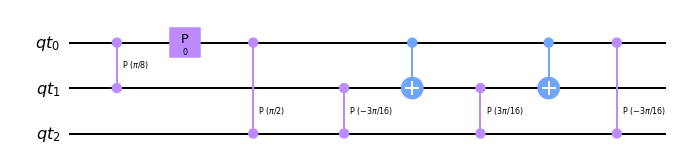

In [3]:
at = 0
bt = pi/2
ct = pi/8
dt = pi/4

qt = QuantumRegister(3, 'qt')
qct = QuantumCircuit(qt)

qct.cp(ct - at, qt[0], qt[1])
qct.p(at, qt[0])
qct.cp(bt - at, qt[0], qt[2])

qct.cp((dt - ct + at - bt)/2, qt[1], qt[2])
qct.cx(qt[0], qt[1])
qct.cp(-(dt - ct + at - bt)/2, qt[1], qt[2])
qct.cx(qt[0], qt[1])
qct.cp((dt - ct + at - bt)/2, qt[0], qt[2])

qct.draw()

#### Simulador do Operador Unitário

In [4]:
backend_unitary_t = Aer.get_backend('unitary_simulator')
job_unitary_t = execute(qct, backend_unitary_t, shots=8192)
count_unitary_t = job_unitary_t.result().get_unitary()
array_to_latex(count_unitary_t, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

#### Versão invertida

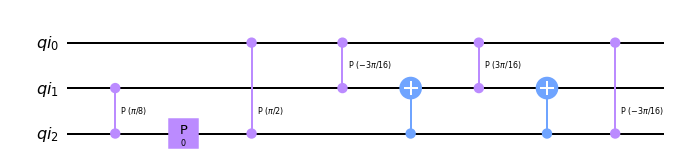

In [5]:
ai = 0
bi = pi/2
ci = pi/8
di = pi/4

qi = QuantumRegister(3, 'qi')
qci = QuantumCircuit(qi)


qci.cp(ci - ai, qi[2], qi[1])
qci.p(ai, qi[2])
qci.cp(bi - ai, qi[2], qi[0])

qci.cp((di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp(-(di - ci + ai - bi)/2, qi[1], qi[0])
qci.cx(qi[2], qi[1])
qci.cp((di - ci + ai - bi)/2, qi[2], qi[0])

qci.draw()

#### Simulador do Operador Unitário da Versão Invertida

In [6]:
backend_unitary_i = Aer.get_backend('unitary_simulator')
job_unitary_i = execute(qci, backend_unitary_i, shots=8192)
count_unitary_i = job_unitary_i.result().get_unitary()
array_to_latex(count_unitary_i, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

## Construindo o Circuito

In [7]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Qubits; a,b,c,d = Fases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # C-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # C-U1(b-a)
    
    # CCU1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

##### $U\ =\ U_{1}\ \otimes\ U_{2}\ \otimes\ U_{3}\ \otimes\ U_{4}$

In [8]:
def U(times, qc, unit, eigen, phases: list): # a,b,c = fases para U1; d,e,f = fases para U2; g,h,i = fases para U3; j,k,l = fases para U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])

##### $CU$, $CU^{2}$, $CU^{4}$, $CU^{8}$, $CU^{16}$, $CU^{32}$

In [9]:
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

Lets consider all the phases:

The phases are normalized to be bound within $[0,\ 2π]$ once we know the range of distances between the cities.

<table>
    <tr>
        <th>Phases</th>
        <th>Encoded as</th>
        <th>Phase value</th>
    </tr>
    <tr>
        <td>$\phi_{1\to1}$</td>
        <td></td>
        <td>$\text{0}$</td>
    </tr>
    <tr>
        <td>$\phi_{2\to1}$</td>
        <td>$\text{a}$</td>
        <td>$\frac{\pi}{2}$</td>
    </tr>
    <tr>
        <td>$\phi_{3\to1}$</td>
        <td>$\text{b}$</td>
        <td>$\frac{\pi}{8}$</td>
    </tr>
    <tr>
        <td>$\phi_{4\to1}$</td>
        <td>$\text{c}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>--</td>
        <td>--</td>
        <td>--</td>
    </tr>
    <tr>
        <td>$\phi_{1\to2}$</td>
        <td>$\text{d}$</td>
        <td>$\frac{\pi}{2}$</td>
    </tr>
    <tr>
        <td>$\phi_{2\to2}$</td>
        <td></td>
        <td>$\text{0}$</td>
    </tr>
    <tr>
        <td>$\phi_{3\to2}$</td>
        <td>$\text{e}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>$\phi_{4\to2}$</td>
        <td>$\text{f}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>--</td>
        <td>--</td>
        <td>--</td>
    </tr>
    <tr>
        <td>$\phi_{1\to3}$</td>
        <td>$\text{g}$</td>
        <td>$\frac{\pi}{8}$</td>
    </tr>
    <tr>
        <td>$\phi_{2\to3}$</td>
        <td>$\text{h}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>$\phi_{3\to3}$</td>
        <td></td>
        <td>$\text{0}$</td>
    </tr>
    <tr>
        <td>$\phi_{4\to3}$</td>
        <td>$\text{i}$</td>
        <td>$\frac{\pi}{8}$</td>
    </tr>
    <tr>
        <td>--</td>
        <td>--</td>
        <td>--</td>
    </tr>
    <tr>
        <td>$\phi_{1\to4}$</td>
        <td>$\text{j}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>$\phi_{2\to4}$</td>
        <td>$\text{k}$</td>
        <td>$\frac{\pi}{4}$</td>
    </tr>
    <tr>
        <td>$\phi_{3\to4}$</td>
        <td>$\text{l}$</td>
        <td>$\frac{\pi}{8}$</td>
    </tr>
    <tr>
        <td>$\phi_{4\to4}$</td>
        <td></td>
        <td>$\text{0}$</td>
    </tr>
</table>


Construindo os autoestados

In [10]:
# Guardando os autoestados em um array
eigen_values = ["11000110", "10001101", "11001001"]

# Função para atribuir o gate apropriado do autoestado
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

Construindo o Circuito

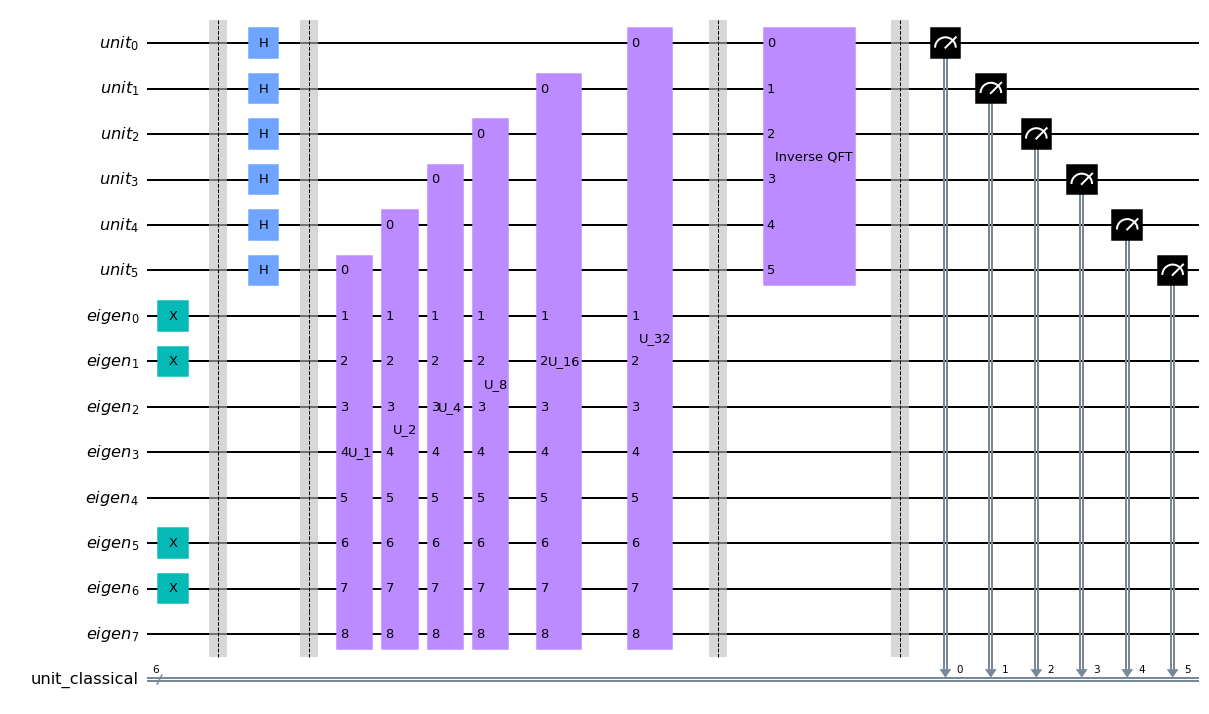

In [11]:
# Inicialização
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Escolhendo o primeiro autoestado
eigenstates(qc, eigen, 0)

# Aplicando Hadamard nos 'unit' qubits
qc.h(unit[:])
qc.barrier()

# C-U  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
#

# Inversa de QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Medida
qc.measure(unit, unit_classical)
#

# Desenho
qc.draw()

#### Medida <a id="qasm_simulator"></a>

{'100100': 8192}


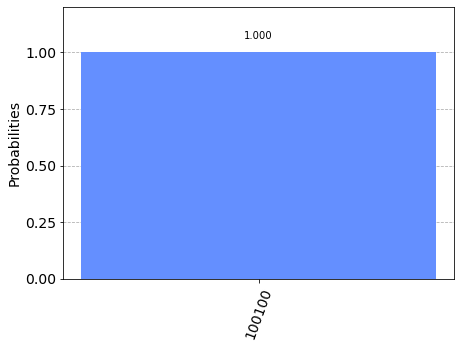

In [12]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192)
count = job.result().get_counts()
print(count)
plot_histogram(count)

Esse notebook é parte integrante do artigo "Solving the Travelling Salesman on IBM Quantum" de autoria de Natália Capra Ferrazzo.

## Referências

* [1]. Karthik Srinivasan, Saipriya Satyajit, Bikash K Behera, and Prasanta K Panigrahi. [Efficient quantum algorithm for solving travelling salesman problem: An IBM quantum experience](https://arxiv.org/abs/1805.10928). *arXiv:1805.10928v1, 2018*.

* [1]. Qiskit Team. [Solving the Travelling Salesman Problem using Phase Estimation](https://qiskit.org/textbook/ch-paper-implementations/tsp.html). *2021*.

* [2]. Adriano Barenco, Charles H. Bennett, Richard Cleve, David P. DiVincenzo, Norman Margolus, Peter Shor, Tycho Sleator, John Smolin, Harald Weinfurter. [Elementary gates for quantum computation](https://arxiv.org/abs/quant-ph/9503016). *arXiv:9503016v1, 1995*.
